# Contradictory, My Dear Watson

### Task Description

"Contradictory, My Dear Watson" is a kaggle competition in which one is given the task of labeling pairs of (premise, hypothesis) into either an entailment, neutral or contradiction).

> If you have two sentences, there are three ways they could be related: one could entail the other, one could contradict the other, or they could be unrelated. Natural Language Inferencing (NLI) is a popular NLP problem that involves determining how pairs of sentences (consisting of a premise and a hypothesis) are related.

> Your task is to create an NLI model that assigns labels of 0, 1, or 2 (corresponding to entailment, neutral, and contradiction) to pairs of premises and hypotheses. To make things more interesting, the train and test set include text in fifteen different languages! You can find more details on the dataset by reviewing the Data page.

> Today, the most common approaches to NLI problems include using embeddings and transformers like BERT. In this competition, we’re providing a starter notebook to try your hand at this problem using the power of Tensor Processing Units (TPUs). TPUs are powerful hardware accelerators specialized in deep learning tasks, including Natural Language Processing. Kaggle provides all users TPU Quota at no cost, which you can use to explore this competition. Check out our TPU documentation and Kaggle’s YouTube playlist for more information and resources.



### NLI State of the Art

As of 2019, BERT became the industry standard Transformer for building contextual word representations and the fundation for state-of-the-art solution for different NLP tasks (such as question answering or language inference).

Since BERT gained a lot of community traction and popularity in the NLP field, we've decided to experiment with a BERT-based NLP model on the dataset from kaggle.

As a comparison, we've also worked with a RNN based model – a "Siamese Recurrent Network" with LSTM layers for contextual learning. For this model, we've used Paul Necoiu's, Maarten Versteegh and Mihai Rotaru's work entitled "Learning Text Similarity with Siamese Recurrent Networks".
> https://github.com/GKarmakar/siamese-lstm/blob/master/docs/W16-1617.pdf

### Kaggle dataset

The Kaggle dataset is composed of multiple pairs of `(premise, hypothesis)` in different languages (English, French, Italian, Chinese etc.) and they are labeled with either `0`, `1` or `2`, according to: neutral, entailment or contradiction.

For our experiments, we've only worked with the items in English, since this composed more than 50% of the dataset and it would also allow us to experiment easier with the trained models.

In [30]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print(f"Train: {train_df.shape}, Test: {test_df.shape}")

Train: (12120, 6), Test: (5195, 5)


In [31]:
train_df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [32]:
train_df.iloc[0]

id                                                   5130fd2cb5
premise       and these comments were considered in formulat...
hypothesis    The rules developed in the interim were put to...
lang_abv                                                     en
language                                                English
label                                                         0
Name: 0, dtype: object

/Users/sergiuiacob/.pyenv/versions/3.7.8/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


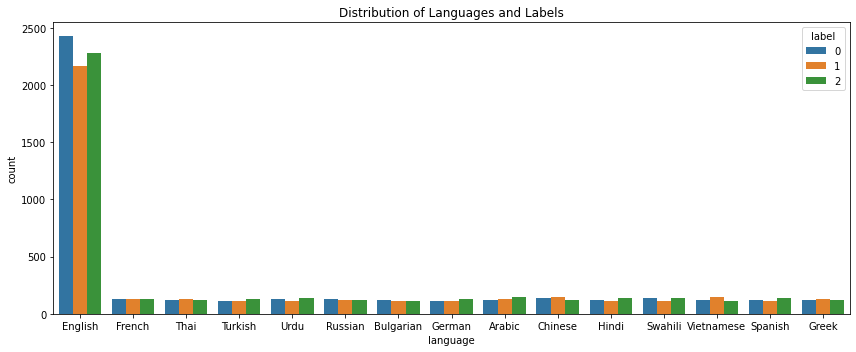

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize = (12,5))

palette = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)

graph1 = sns.countplot(train_df['language'], hue = train_df['label'])#, palette = palette)

graph1.set_title('Distribution of Languages and Labels')

plt.tight_layout()
plt.show()

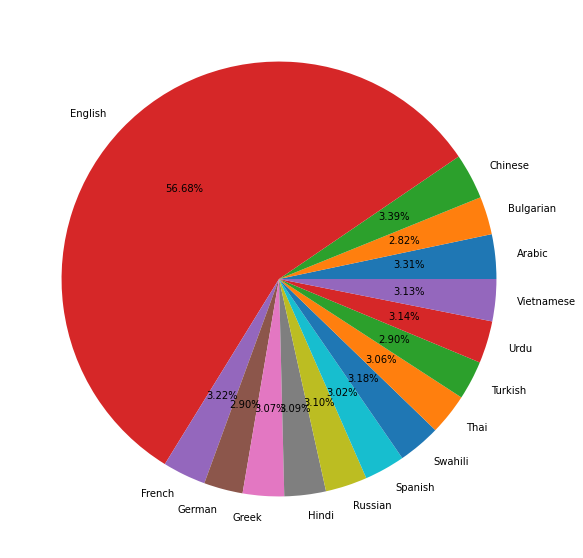

In [34]:
labels, freqs = np.unique(train_df['language'].values, return_counts=True)

plt.figure(figsize=(10,10))
plt.pie(freqs, labels = labels , autopct = "%1.2f%%")
plt.show()

In [35]:
train_df = train_df[train_df['language'] == 'English']
test_df = test_df[test_df['language'] == 'English']
print(f"Train: {train_df.shape}, Test: {test_df.shape}")

Train: (6870, 6), Test: (2945, 5)


#### Word Encoding – Word2Vec
For our RNN LSTM based model, we've decided to use word2vec as our text representation. Word2vec can work with 2 strategies – CBOW (Continuous Bag of Words) or SkipGram. We've chosen to work with CBOW.



<img src="cbow_1.png">

In CBOW, the primary task is to build a language model that correctly predicts the center word given the context words in which the center word appears. Consider our example sentence we take the word “jumps” as the center word, then its context is formed by words in its vicinity. If we take the context size of 2, then for our example, the context is given by brown, fox, over, the. CBOW uses the context words to predict the target word—jumps—as shown in the below figure


<img src="cbow_2.png">

Now next task is to create a training sample of the form (X, Y) for this task where X will be context words and Y will be Center word. We define the value of context window = 2 in this case.

Now that we have the training data ready, let’s focus on the model. For this, we construct a shallow net (it’s shallow since it has a single hidden layer). We assume we want to learn D-dim word embeddings. Further, let V be the vocabulary of the text corpus

<img src="cbow_3.png">

The objective is to learn an embedding matrix E|V| x d.To begin with, we initialize the matrix randomly. Here, |V| is the size of corpus vocabulary and d is the dimension of the embedding. Let’s break down the shallow net in Figure layer by layer. In the input layer, indices of the words in context are used to fetch the corresponding rows from the embedding matrix E|V| x d. The vectors fetched are then added to get a single D-dim vector, and this is passed to the next layer. The next layer simply takes this d vector and multiplies it with another matrix E’d x |V|.. This gives a 1 x |V| vector, which is fed to a softmax function to get probability distribution over the vocabulary space. This distribution is compared with the label and uses backpropagation to update both the matrices E and E’ accordingly. At the end of the training, E is the embedding matrix we wanted to learn.


In [71]:
import nltk
from gensim.models import word2vec
import re
from sklearn.manifold import TSNE

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergiuiacob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [61]:
temp = pd.DataFrame()
temp['premise'] = train_df['premise']
temp['hypothesis'] = train_df['hypothesis']

In [62]:
STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

temp['premise'] =  temp['premise'].apply(clean_sentence)
temp['hypothesis'] =  temp['hypothesis'].apply(clean_sentence)

In [63]:
def build_corpus(data):
    corpus = []
    for col in ['premise', 'hypothesis']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(temp)

In [64]:
print(temp['premise'][:2], "\n", corpus[:2])

0     comments considered formulating interim rules
1    issues wrestle practice groups law firms said 
Name: premise, dtype: object 
 [['comments', 'considered', 'formulating', 'interim', 'rules'], ['issues', 'wrestle', 'practice', 'groups', 'law', 'firms', 'said', '']]


In [65]:
def tsne_plot(model, word_limit=100):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in list(model.wv.key_to_index)[:word_limit]:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [66]:
encoder = word2vec.Word2Vec(corpus, vector_size=100, window=20, min_count=5, workers=8)

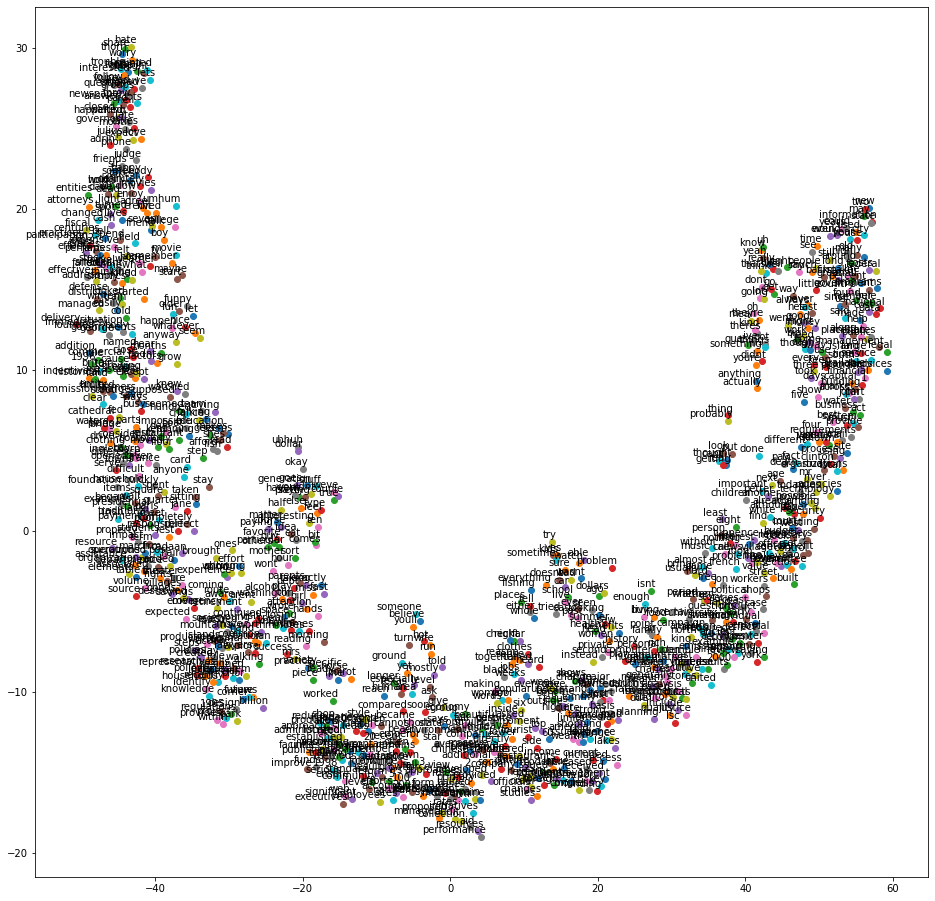

In [80]:
tsne_plot(encoder, word_limit=1000)

## BiLSTM Network – Representative schema

> https://github.com/GKarmakar/siamese-lstm/blob/master/docs/W16-1617.pdf

<img src="bilstm.png">

## BERT – Representative schema
> https://profs.info.uaic.ro/~nlp/documente/DL-NLP-curs13-transformers.pdf

> https://towardsml.com/2019/09/17/bert-explained-a-complete-guide-with-theory-and-tutorial/

> https://huggingface.co/docs/transformers/model_doc/bert

<img src="bert_1.png">